![](../figure/unsupervised-workflow.png)

In [69]:
# Basic 
import sys
import json

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Profiling process
from tqdm import tqdm

# Reporting result
from IPython.display import display

import pickle

# Math
import numpy as np
import scipy as sp
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# CLustering
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering

# Resampling
from imblearn.under_sampling import ClusterCentroids
from sklearn.utils import resample

# Dimension reductionality
from sklearn.decomposition import PCA

plt.style.use('default')

# === Color pallete ===
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0),  # Yellow
    (236, 163, 245),# Magenta
    (152, 221, 202),# Cyan
    (204, 155, 109),# Brown
    (160, 147, 125),# Dark Brown
    (241, 202, 137),# Soft Brown
]

light_palette = np.array(raw_light_palette)/255

# Color constant
color1 = "#F36E8E"
color2 = "#1ABDE9"

In [70]:
# Saving model 
def save_model(model, name="model"):
    pickle.dump(model, open(f"../bin/{name}", "wb"))

## Data Preparation

In [71]:
from umap.umap_ import UMAP

In [72]:
filename = "../data/processed/rfm-unsupervised-dataset.pkl"
df = pd.read_pickle(filename)

**Sampling**

In [73]:
mask = df.frequency == 1
df_sampled = df.loc[~mask]
df_single_time = df.loc[mask]

In [74]:
df_single_time_resample = resample(df_single_time, 
         replace = False, 
         n_samples = 10000,
        random_state = 123) # reproducible results

In [75]:
df_sampled = pd.concat([df_sampled, df_single_time_resample])

**Normalization**

In [76]:
df_norm = df_sampled.copy()
df_norm['recency'] = (df_norm['recency']).apply(np.sqrt)
df_norm['monetary'] = (df_norm['monetary'] + 1).apply(np.log)

**Scaling**

In [77]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
cols = [
    "recency",
    "frequency",
    "monetary",
]
scaler.fit(df_norm[cols])
scaled_data = scaler.transform(df_norm[cols])  

In [78]:
df_std = df_sampled[['user_name']]
df_std[cols] = scaled_data

In [79]:
pca = PCA(n_components=2)
pca.fit(df_std[cols])
embeddings = pca.transform(df_std[cols])

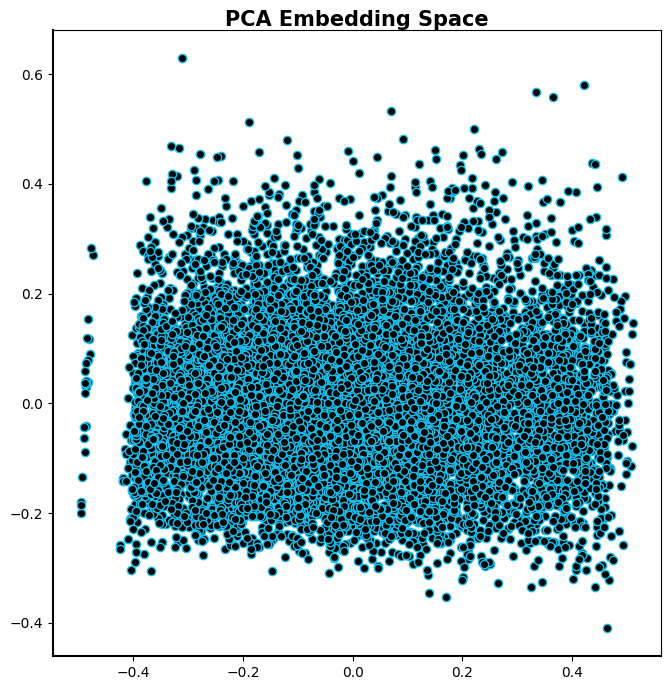

In [80]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, aspect=1)

x = embeddings[:,0]
y = embeddings[:,1]

ax.scatter(x, y, 
           c='k',
           linewidth=1,
           edgecolor=color2)

ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

ax.set_title(f"PCA Embedding Space", fontsize=15,va= 'center', fontweight='semibold')

plt.tight_layout()
plt.show()

In [81]:
# === Save embedding ===
file = "../data/processed/rfm-unsupervised-embedding-pca-sampled.pkl"
pickle.dump(embeddings, open(file, "wb"))

In [87]:
umap = UMAP(n_components=2, random_state=123)
embeddings_umap = umap.fit_transform(df_std[cols])

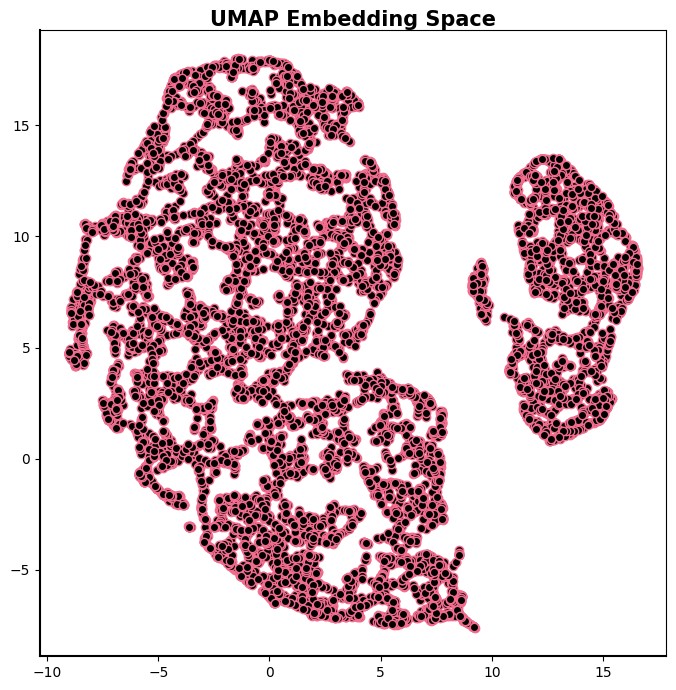

In [88]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, aspect=1)

x = embeddings_umap[:,0]
y = embeddings_umap[:,1]

ax.scatter(x, y, 
           c='k',
           linewidth=1,
           edgecolor=color1)

ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

ax.set_title(f"UMAP Embedding Space", fontsize=15,va= 'center', fontweight='semibold')

plt.tight_layout()
plt.show()

**We will use UMAP embedding space as it seems more seperated than PCA**

In [89]:
file = "../data/processed/rfm-unsupervised-embedding-umap-sampled.pkl"
pickle.dump(embeddings_umap, open(file, "wb"))

In [90]:
# === Load Embedding ===
with open("../data/processed/rfm-unsupervised-embedding-umap-sampled.pkl", 'rb') as f:
    embeddings_umap = pickle.load(f)

## EDA

**Before Normalization**

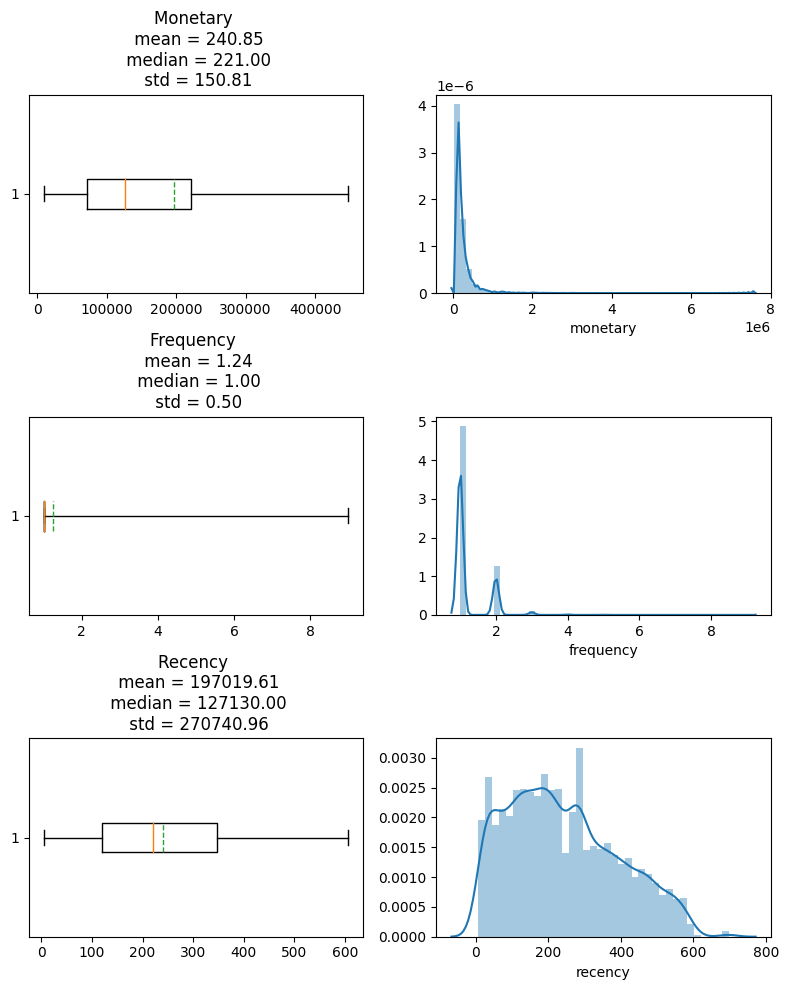

In [91]:
fig = plt.figure(figsize=(8,10))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

ax1.boxplot(df_sampled.monetary, showmeans=True, showfliers=False, autorange=True, meanline=True, vert=False)
sns.distplot(df_sampled.monetary, ax=ax2)
ax3.boxplot(df_sampled.frequency, showmeans=True, showfliers=False, autorange=True, meanline=True, vert=False)
sns.distplot(df_sampled.frequency, ax=ax4)
ax5.boxplot(df_sampled.recency, showmeans=True, showfliers=False, autorange=True, meanline=True, vert=False)
sns.distplot(df_sampled.recency, ax=ax6)
axs = [ax1,ax3,ax5]
titles = ['Monetary', 'Frequency', 'Recency']
for ax, title, col in zip(axs, titles, cols):
    ax.set_title(f'{title} \n mean = %.2f\n median = %.2f\n std = %.2f'%(df_sampled[col].mean(), df_sampled[col].median(), df_sampled[col].std()))

plt.tight_layout()
plt.show()

**After Normalization**

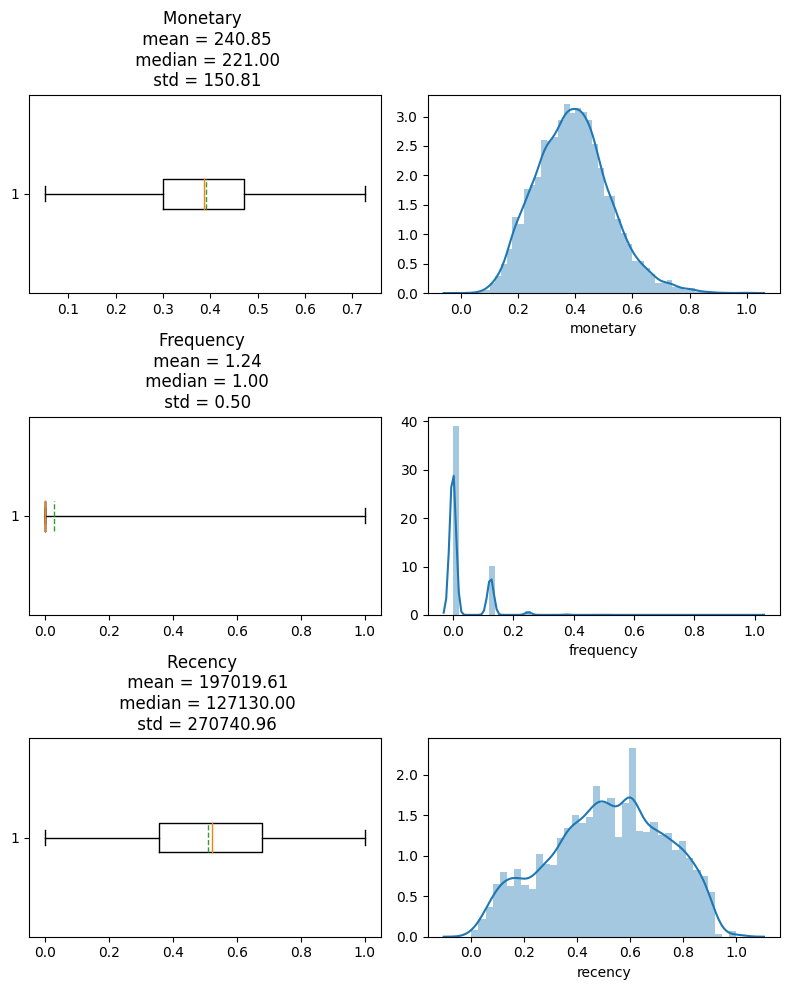

In [92]:
fig = plt.figure(figsize=(8,10))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

ax1.boxplot(df_std.monetary, showmeans=True, showfliers=False, autorange=True, meanline=True, vert=False)
sns.distplot(df_std.monetary, ax=ax2)
ax3.boxplot(df_std.frequency, showmeans=True, showfliers=False, autorange=True, meanline=True, vert=False)
sns.distplot(df_std.frequency, ax=ax4)
ax5.boxplot(df_std.recency, showmeans=True, showfliers=False, autorange=True, meanline=True, vert=False)
sns.distplot(df_std.recency, ax=ax6)
axs = [ax1,ax3,ax5]
titles = ['Monetary', 'Frequency', 'Recency']
for ax, title, col in zip(axs, titles, cols):
    ax.set_title(f'{title} \n mean = %.2f\n median = %.2f\n std = %.2f'%(df_sampled[col].mean(), df_sampled[col].median(), df_sampled[col].std()))

plt.tight_layout()
plt.show()

## Unsupervised Modelling

### K-means

In [95]:
from scipy.spatial.distance import cdist

scores = []
K = range(3,10,1) 
  
for k in tqdm(K): 
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(df_std[cols])     
    
    # Save silhoete score
    label = kmeans.labels_
    scores.append(silhouette_score(df_std[cols], label, metric='euclidean')) 

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:23<00:00,  3.41s/it]


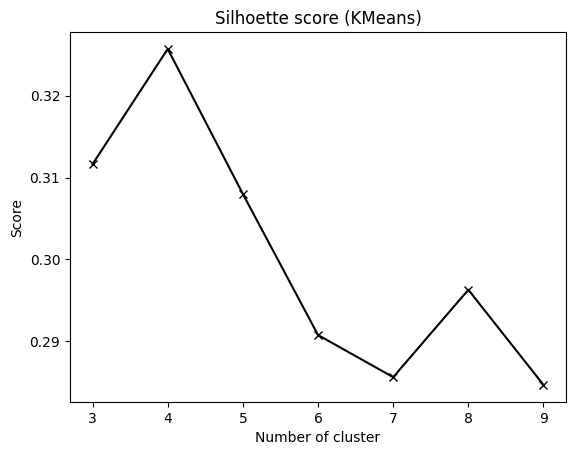

In [96]:
plt.plot(K, scores, 'bx-', c='k') 
plt.xlabel('Number of cluster') 
plt.ylabel('Score') 
plt.title('Silhoette score (KMeans)')
plt.savefig("../reports/visualization/kmeans-silhoette.jpg")
plt.show()

**Finalize & Visualize Embedding** (best k=4)

In [97]:
k=4
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(df_std[cols])   
labels = kmeans.labels_

# === Merging original data ===
df_kmeans = df_sampled[['recency', 'frequency', 'monetary']].copy()
df_kmeans['cluster'] = labels
df_kmeans.to_pickle("../data/processed/rfm-unsupervised-kmeans-cluster.pkl", protocol=4)

In [98]:
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12803 entries, 104 to 28851
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    12803 non-null  float64
 1   frequency  12803 non-null  float64
 2   monetary   12803 non-null  float64
 3   cluster    12803 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 450.1 KB


In [99]:
viz_kmeans = pd.DataFrame({
    'x' : embeddings_umap[:,0],
    'y' : embeddings_umap[:,1],
    'label' : labels
})
viz_kmeans.head()

x          y  label
0  13.270793   6.835030      3
1  14.339145  11.564841      0
2  12.186145   1.273123      2
3  14.238850   9.827394      3
4  14.378018   7.679470      3

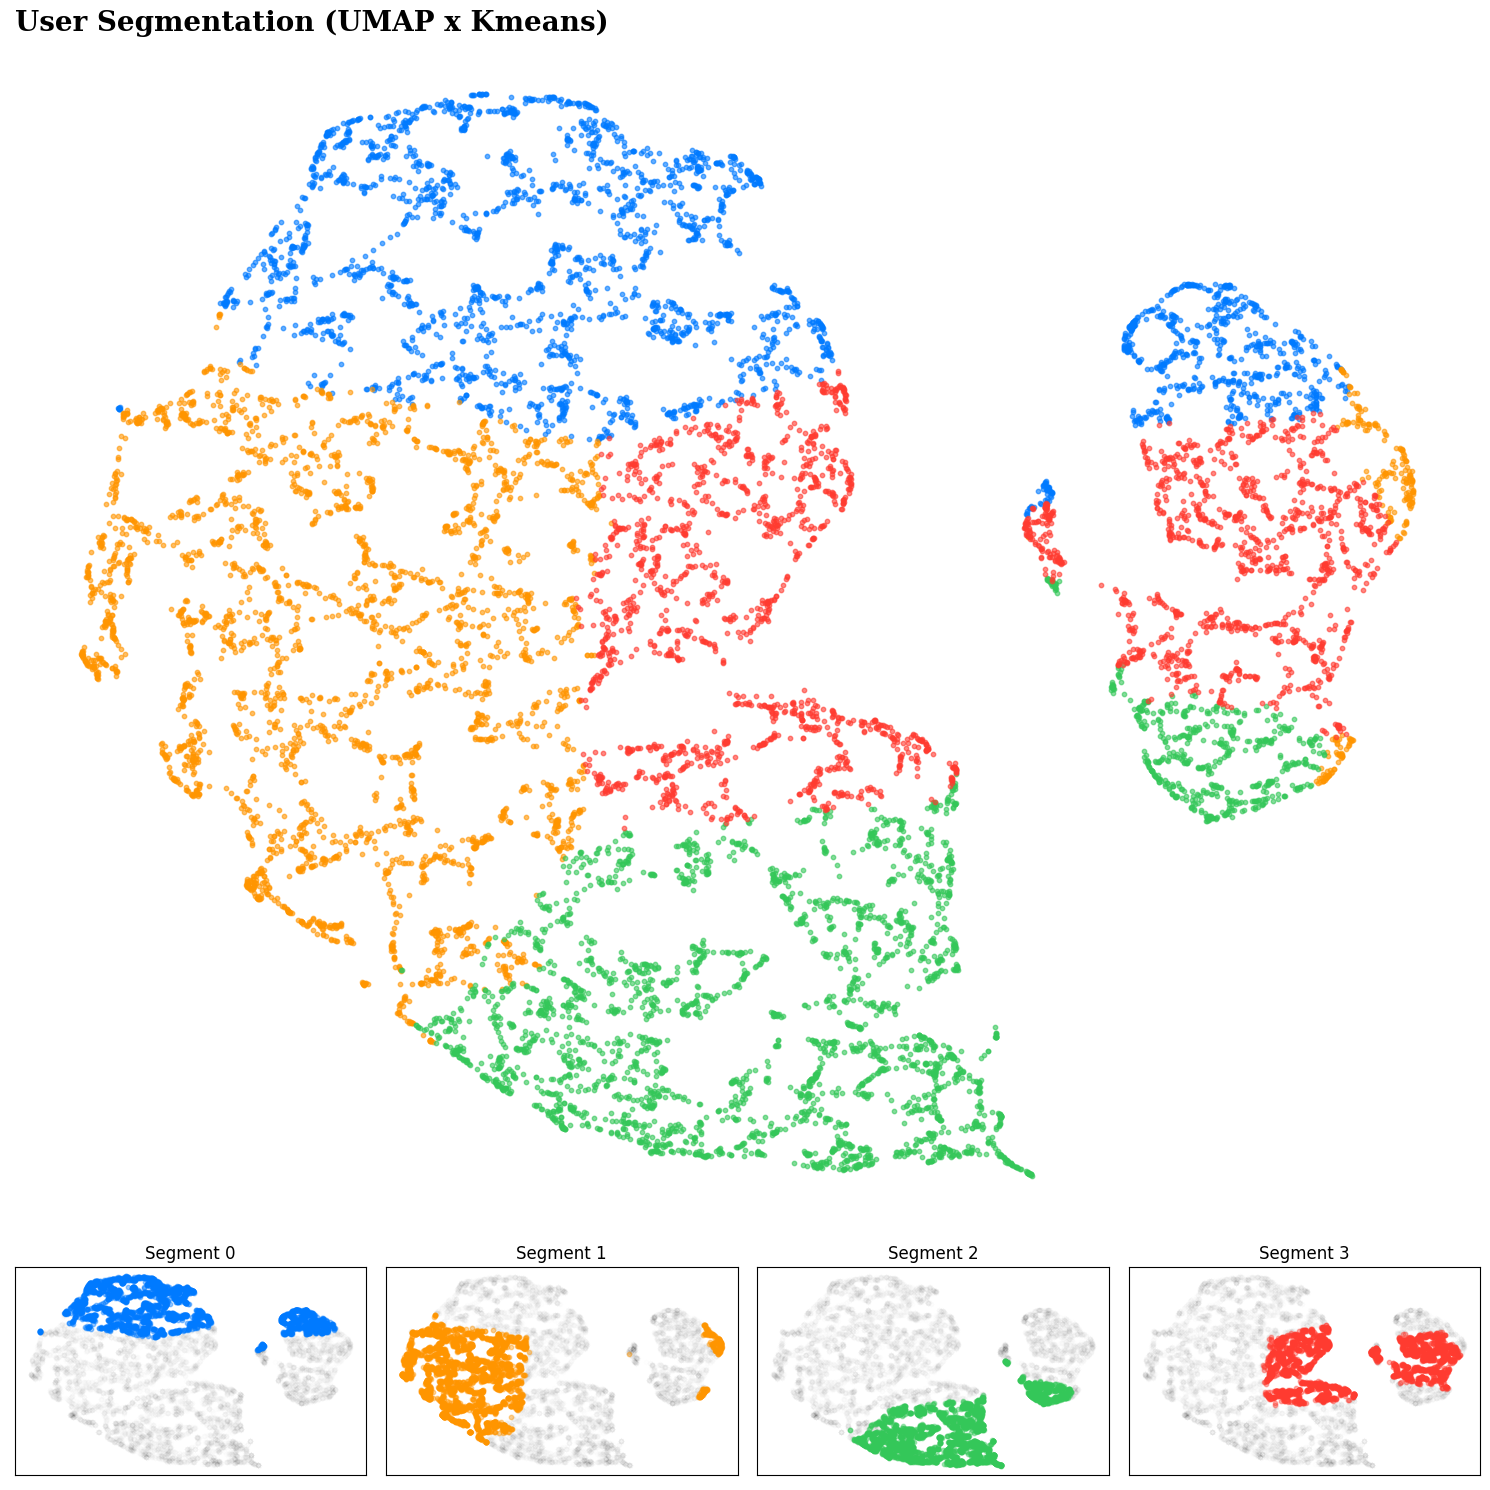

In [100]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(6, k)
ax = fig.add_subplot(gs[:-1,:])

sub_axes = [None] * k
for idx in range(k): 
    sub_axes[idx] = fig.add_subplot(gs[-1:,idx])

for idx in range(k):
    data = viz_kmeans.loc[viz_kmeans.label == idx]
    x = data['x']
    y = data['y']
    ax.scatter(x=x, y=y, color=light_palette[idx],
              s=10, alpha=0.6
              )

    for j in range(k):
        sub_axes[j].scatter(x=x, y=y,
                            s=10, alpha = 0.4 if idx==j else 0.008, 
                            color = '#%02x%02x%02x' % raw_light_palette[j] if idx==j else 'gray',
                            zorder=(idx==j)
                           )
        
    
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    sub_axes[idx].set_xlabel('')
    sub_axes[idx].set_ylabel('')
    sub_axes[idx].set_title(f'Segment {idx}')
    sub_axes[idx].spines['right'].set_visible(True)
    sub_axes[idx].spines['top'].set_visible(True)

ax.set_title('User Segmentation (UMAP x Kmeans)', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')   
    
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.show()

In [102]:
# === Save K-means model ===
save_model(kmeans, "kmeans-1-revised")

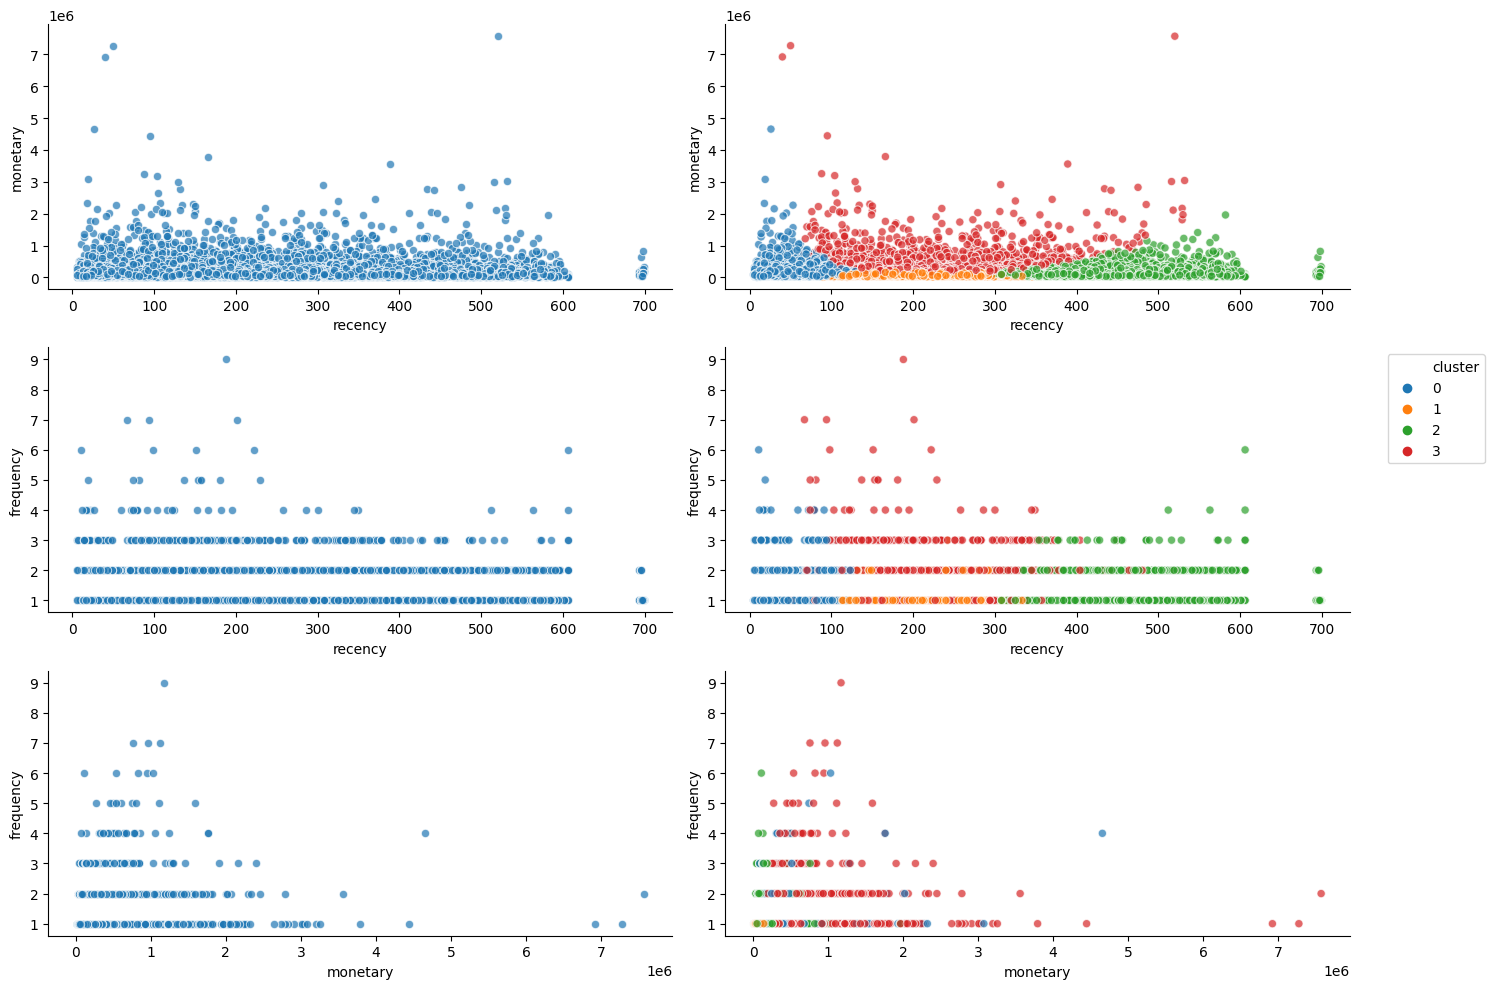

In [103]:
# === Init data ===
with open("../bin/kmeans-1-revised", 'rb') as f:
    kmeans = pickle.load(f)
df_kmeans = pd.read_pickle("../data/processed/rfm-unsupervised-kmeans-cluster.pkl")
df_kmeans['cluster'] = df_kmeans['cluster'].astype('category')

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

sns.scatterplot(data=df_kmeans, x='recency', y='monetary', alpha=0.7, ax=ax[0][0])
sns.scatterplot(data=df_kmeans, x='recency', y='monetary', hue='cluster', alpha=0.7, ax=ax[0][1], legend=False)

sns.scatterplot(data=df_kmeans, x='recency', y='frequency', alpha=0.7, ax=ax[1][0])
sns.scatterplot(data=df_kmeans, x='recency', y='frequency', hue='cluster', alpha=0.7, ax=ax[1][1])

ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.scatterplot(data=df_kmeans, x='monetary', y='frequency', alpha=0.7, ax=ax[2][0])
sns.scatterplot(data=df_kmeans, x='monetary', y='frequency', hue='cluster', alpha=0.7, ax=ax[2][1], legend=False)

for i in range(3):
    for j in range(2):
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### K-medoids

In [104]:
from scipy.spatial.distance import cdist

K = range(3,14,1) 
scores = []  
for k in tqdm(K): 
    kmedoids = KMedoids(n_clusters=k, random_state=123)
    kmedoids.fit(df_std[cols])     
    
    # Save silhoete score
    label = kmedoids.labels_
    scores.append(silhouette_score(df_std[cols], label, metric='euclidean')) 

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:57<00:00, 21.55s/it]


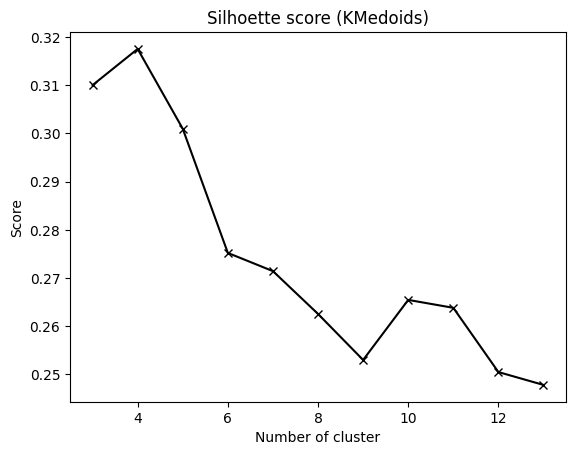

In [105]:
plt.plot(K, scores, 'bx-', c='k') 
plt.xlabel('Number of cluster') 
plt.ylabel('Score') 
plt.title('Silhoette score (KMedoids)') 
plt.show()

**Finalize & Visualize Embedding** (best k=4)

In [106]:
k=4
kmedoids = KMedoids(n_clusters=k, random_state=123)
kmedoids.fit(df_std[cols])   
labels = kmedoids.labels_

# === Merging original data ===
df_kmedoids = df_sampled[['recency', 'frequency', 'monetary']].copy()
df_kmedoids['cluster'] = labels
df_kmedoids.to_pickle("../data/processed/rfm-unsupervised-kmedoids-cluster.pkl", protocol=4)

In [107]:
viz_kmedoids = pd.DataFrame({
    'x' : embeddings_umap[:,0],
    'y' : embeddings_umap[:,1],
    'label' : labels
})
viz_kmedoids.head()

x          y  label
0  13.270793   6.835030      3
1  14.339145  11.564841      1
2  12.186145   1.273123      0
3  14.238850   9.827394      3
4  14.378018   7.679470      3

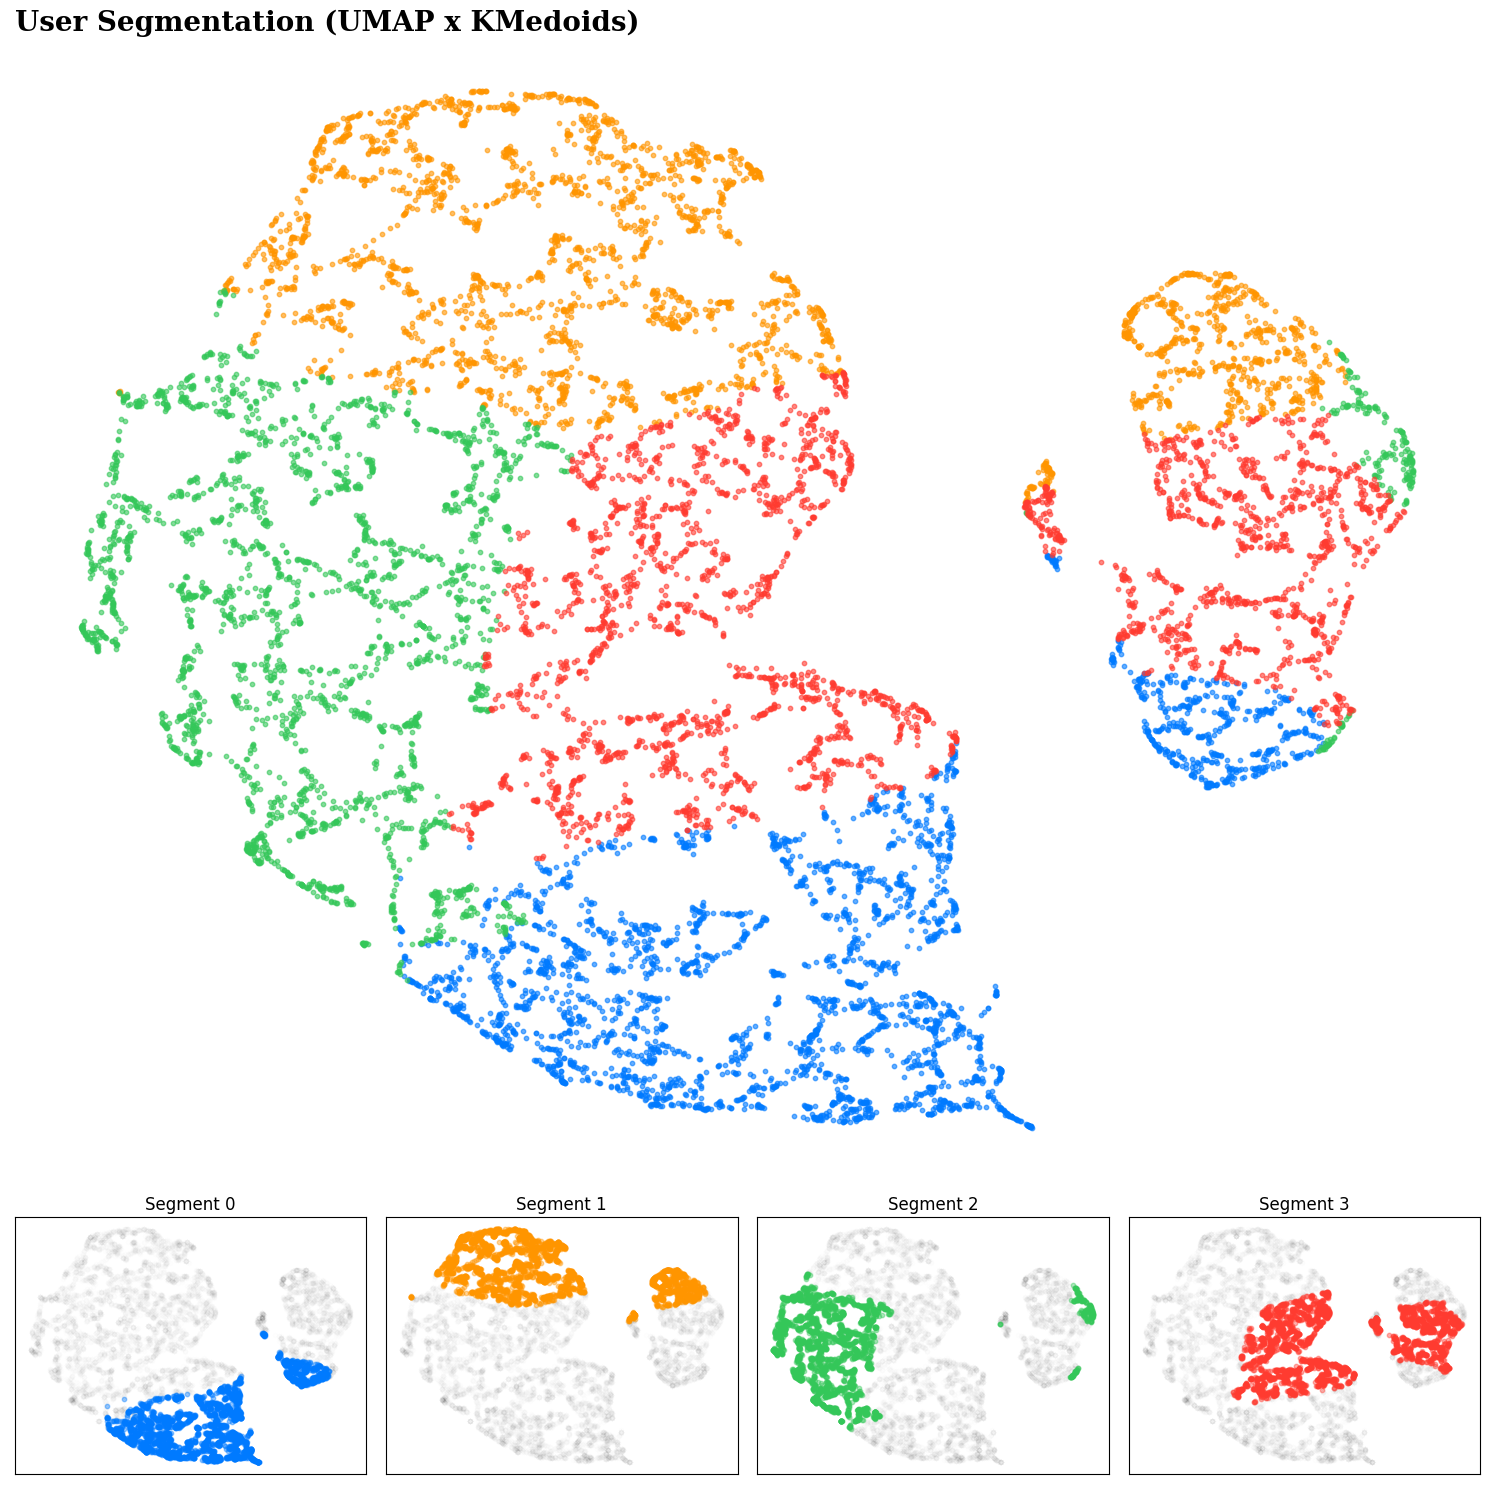

In [108]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(k+1, k)
ax = fig.add_subplot(gs[:-1,:])

sub_axes = [None] * k
for idx in range(k): 
    sub_axes[idx] = fig.add_subplot(gs[-1:,idx])

for idx in range(k):
    data = viz_kmedoids.loc[viz_kmedoids.label == idx]
    x = data['x']
    y = data['y']
    ax.scatter(x=x, y=y, color=light_palette[idx],
              s=10, alpha=0.6
              )

    for j in range(k):
        sub_axes[j].scatter(x=x, y=y,
                            s=10, alpha = 0.4 if idx==j else 0.008, 
                            color = '#%02x%02x%02x' % raw_light_palette[j] if idx==j else 'gray',
                            zorder=(idx==j)
                           )
        
    
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    sub_axes[idx].set_xlabel('')
    sub_axes[idx].set_ylabel('')
    sub_axes[idx].set_title(f'Segment {idx}')
    sub_axes[idx].spines['right'].set_visible(True)
    sub_axes[idx].spines['top'].set_visible(True)

ax.set_title('User Segmentation (UMAP x KMedoids)', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')   
    
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.show()

In [109]:
save_model(kmedoids, "kmedoids-2-revised")

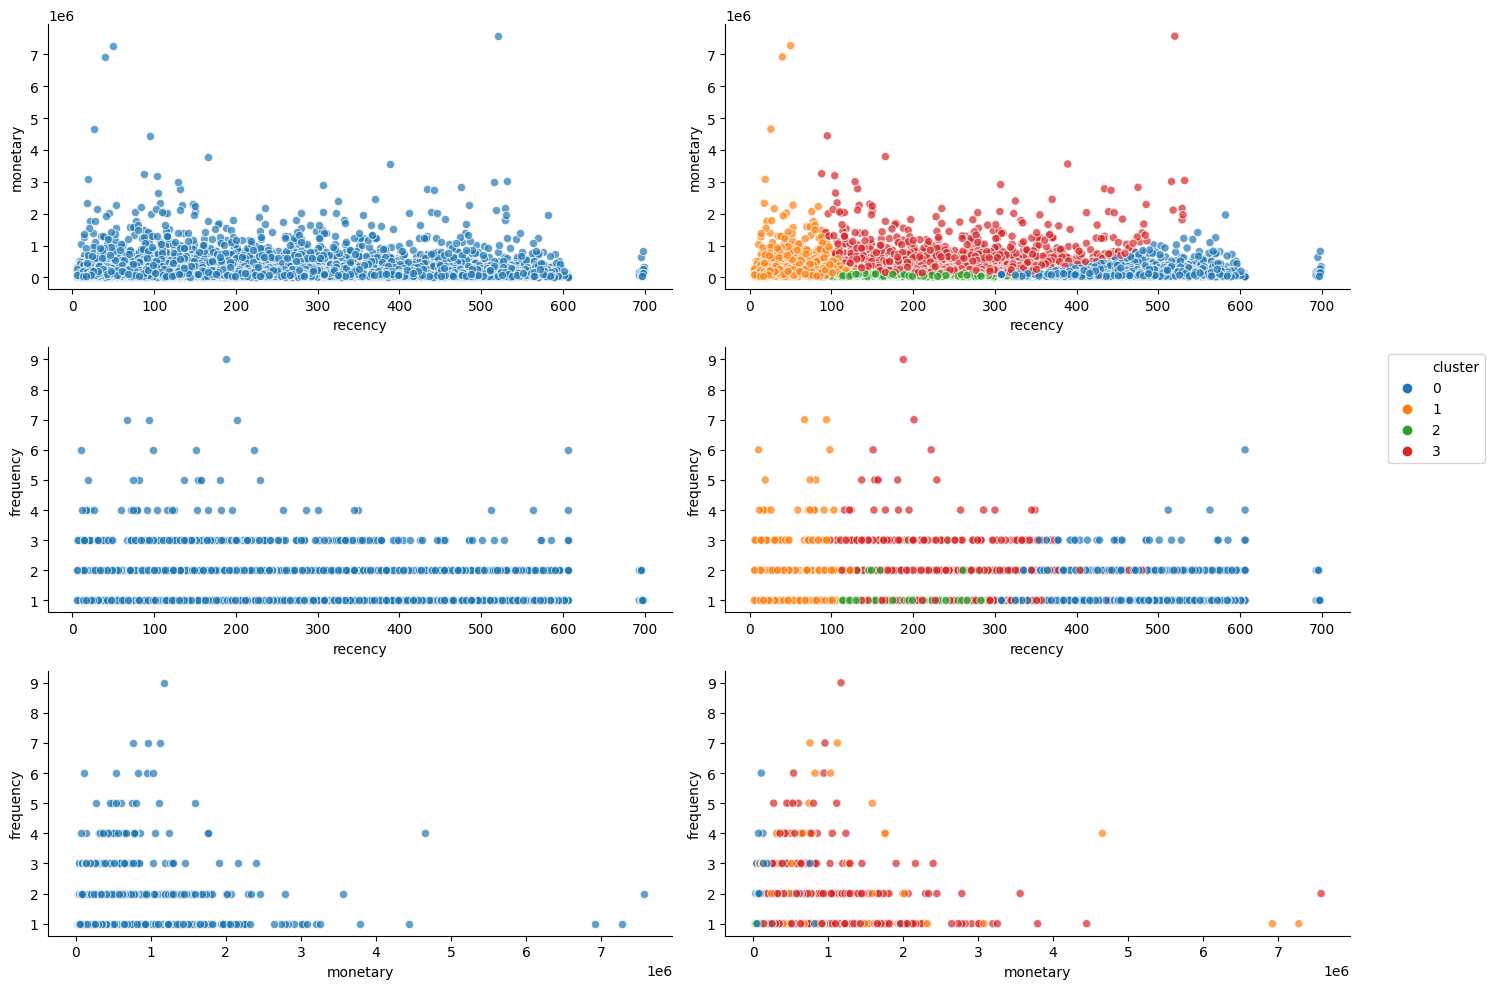

In [110]:
# === Init data ===
with open("../bin/kmedoids-2-revised", 'rb') as f:
    kmedoids = pickle.load(f)
df_kmedoids = pd.read_pickle("../data/processed/rfm-unsupervised-kmedoids-cluster.pkl")
df_kmedoids['cluster'] = df_kmedoids['cluster'].astype('category')

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

sns.scatterplot(data=df_kmedoids, x='recency', y='monetary', alpha=0.7, ax=ax[0][0])
sns.scatterplot(data=df_kmedoids, x='recency', y='monetary', hue='cluster', alpha=0.7, ax=ax[0][1], legend=False)

sns.scatterplot(data=df_kmedoids, x='recency', y='frequency', alpha=0.7, ax=ax[1][0])
sns.scatterplot(data=df_kmedoids, x='recency', y='frequency', hue='cluster', alpha=0.7, ax=ax[1][1])

ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.scatterplot(data=df_kmedoids, x='monetary', y='frequency', alpha=0.7, ax=ax[2][0])
sns.scatterplot(data=df_kmedoids, x='monetary', y='frequency', hue='cluster', alpha=0.7, ax=ax[2][1], legend=False)

for i in range(3):
    for j in range(2):
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Aglomerative Clustering

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_std[cols], method='ward'))

In [111]:
from scipy.spatial.distance import cdist
scores = []
K = range(3,15,1) 
  
for k in tqdm(K): 
    #Building and fitting the model 
    aglo = AgglomerativeClustering(n_clusters=k)
    aglo.fit(df_std[cols])   
    labels = aglo.labels_
    scores.append(silhouette_score(df_std[cols], labels, metric='euclidean')) 

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:03<00:00, 10.30s/it]


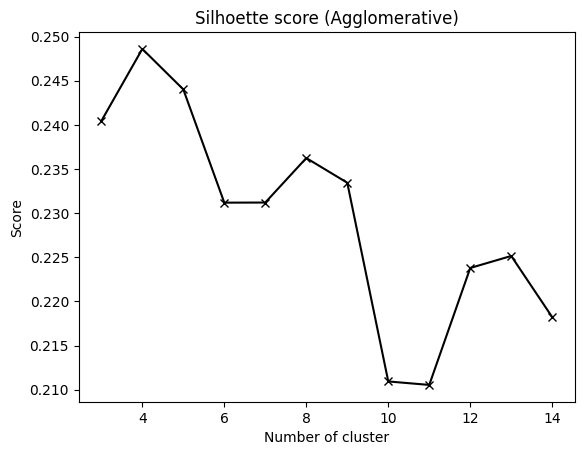

In [112]:
plt.plot(K, scores, 'bx-', c='k') 
plt.xlabel('Number of cluster') 
plt.ylabel('Score') 
plt.title('Silhoette score (Agglomerative)') 
plt.show()

**Finalize & Visualize Embedding** (best k=4)

In [113]:
k=4
aglo = AgglomerativeClustering(n_clusters=k)
aglo.fit(df_std[cols])   
labels = aglo.labels_

# === Merging original data ===
df_aglo = df_sampled[['recency', 'frequency', 'monetary']].copy()
df_aglo['cluster'] = labels
df_aglo.to_pickle("../data/processed/rfm-unsupervised-aglo-cluster.pkl", protocol=4)

In [114]:
viz_aglo = pd.DataFrame({
    'x' : embeddings_umap[:,0],
    'y' : embeddings_umap[:,1],
    'label' : labels
})
viz_aglo.head()

x          y  label
0  13.270793   6.835030      1
1  14.339145  11.564841      1
2  12.186145   1.273123      0
3  14.238850   9.827394      1
4  14.378018   7.679470      1

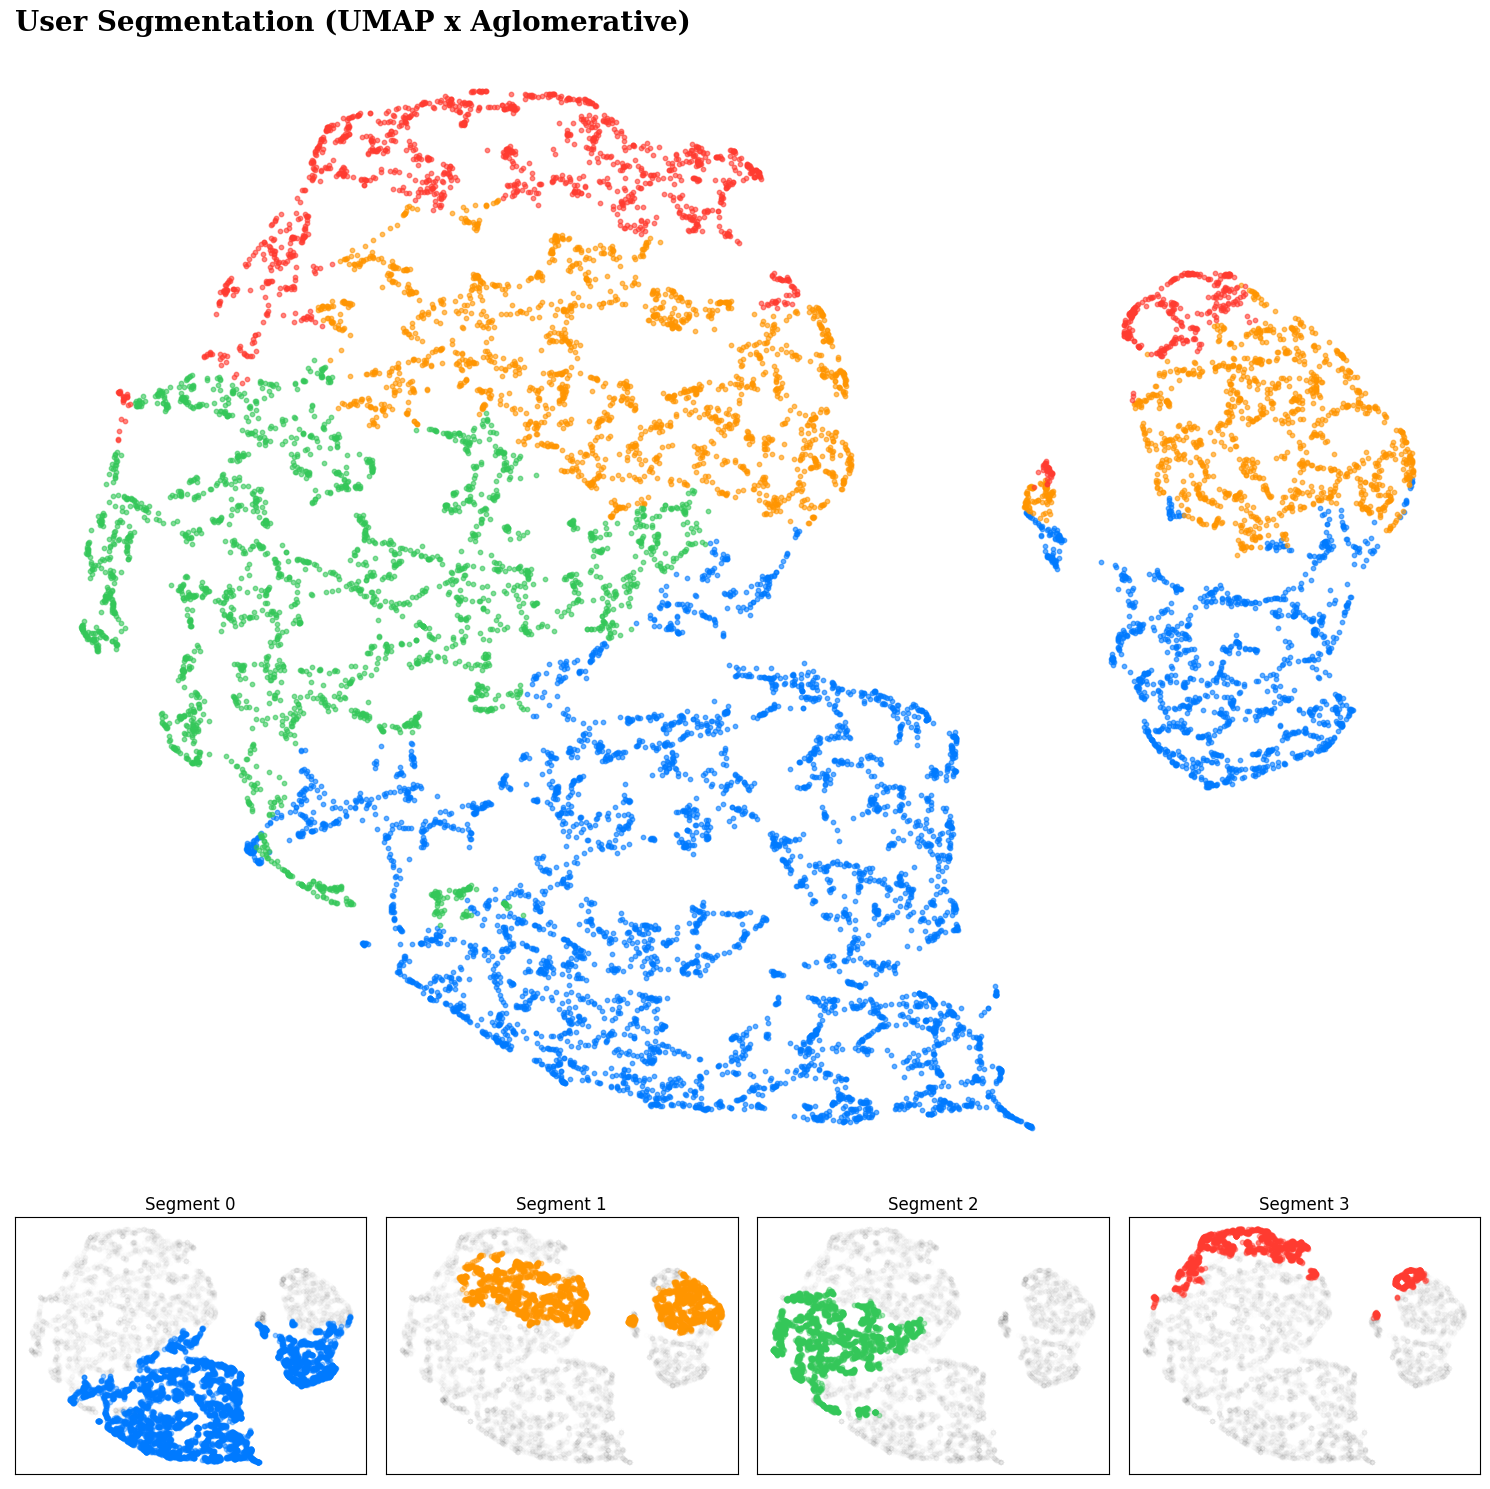

In [115]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(k+1, k)
ax = fig.add_subplot(gs[:-1,:])

sub_axes = [None] * k
for idx in range(k): 
    sub_axes[idx] = fig.add_subplot(gs[-1:,idx])

for idx in range(k):
    data = viz_aglo.loc[viz_aglo.label == idx]
    x = data['x']
    y = data['y']
    ax.scatter(x=x, y=y, color=light_palette[idx],
              s=10, alpha=0.6
              )

    for j in range(k):
        sub_axes[j].scatter(x=x, y=y,
                            s=10, alpha = 0.4 if idx==j else 0.008, 
                            color = '#%02x%02x%02x' % raw_light_palette[j] if idx==j else 'gray',
                            zorder=(idx==j)
                           )
        
    
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    sub_axes[idx].set_xlabel('')
    sub_axes[idx].set_ylabel('')
    sub_axes[idx].set_title(f'Segment {idx}')
    sub_axes[idx].spines['right'].set_visible(True)
    sub_axes[idx].spines['top'].set_visible(True)

ax.set_title('User Segmentation (UMAP x Aglomerative)', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')   
    
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.show()

In [116]:
save_model(df_aglo, "aglo-3-revised")

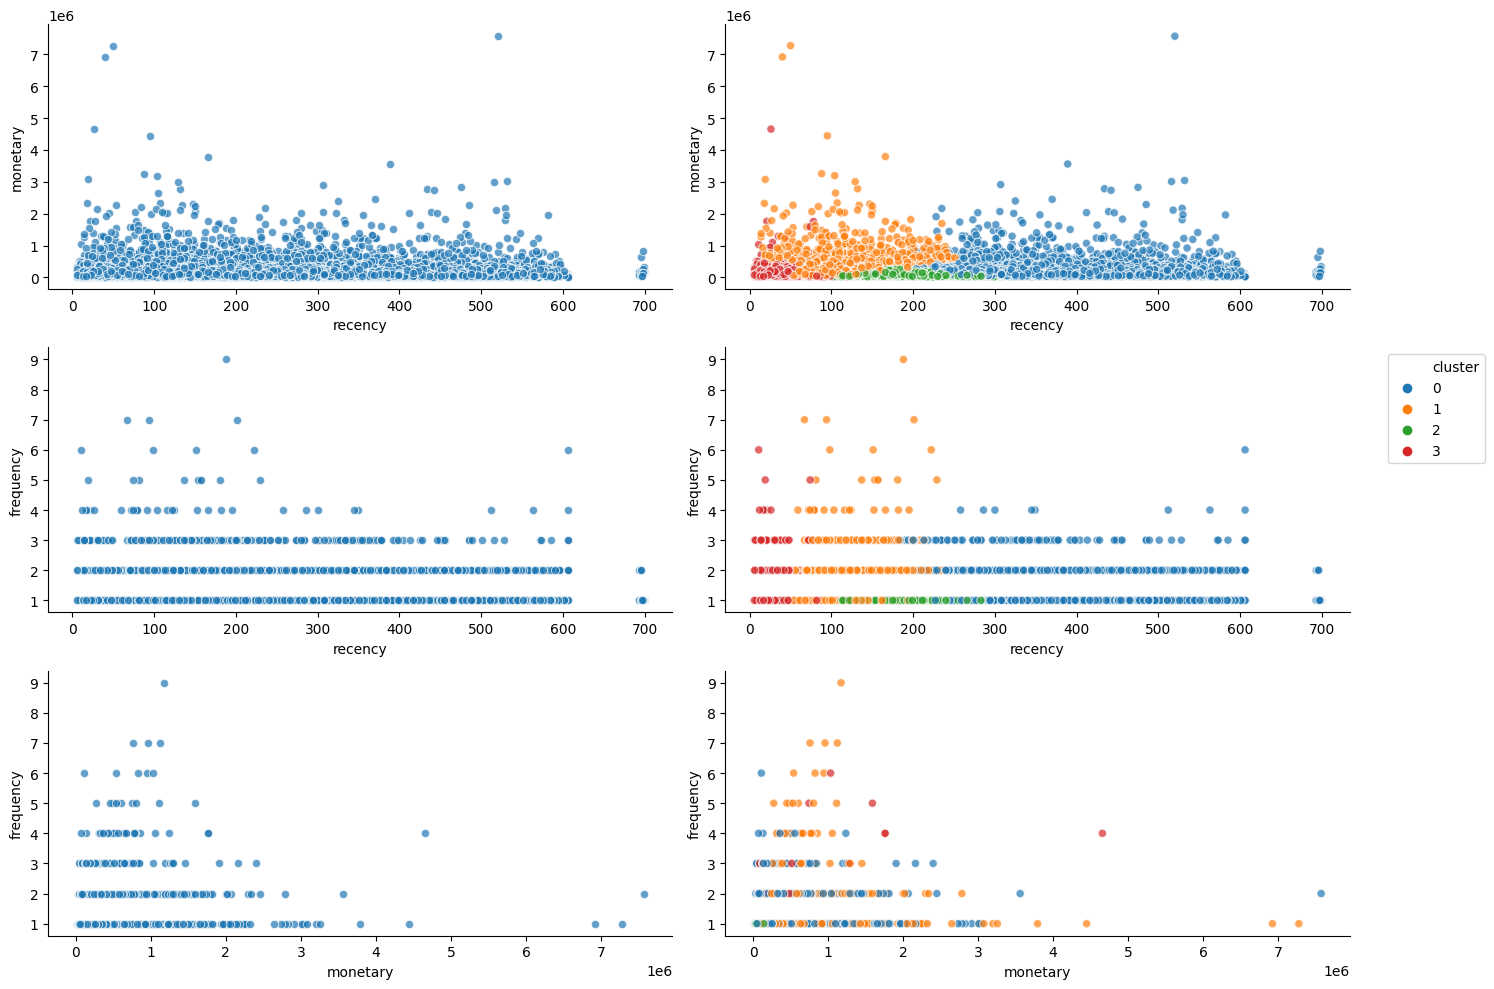

In [117]:
# === Init data ===
with open("../bin/aglo-3-revised", 'rb') as f:
    aglo = pickle.load(f)
df_aglo = pd.read_pickle("../data/processed/rfm-unsupervised-aglo-cluster.pkl")
df_aglo['cluster'] = df_aglo['cluster'].astype('category')

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

sns.scatterplot(data=df_aglo, x='recency', y='monetary', alpha=0.7, ax=ax[0][0])
sns.scatterplot(data=df_aglo, x='recency', y='monetary', hue='cluster', alpha=0.7, ax=ax[0][1], legend=False)

sns.scatterplot(data=df_aglo, x='recency', y='frequency', alpha=0.7, ax=ax[1][0])
sns.scatterplot(data=df_aglo, x='recency', y='frequency', hue='cluster', alpha=0.7, ax=ax[1][1])

ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.scatterplot(data=df_aglo, x='monetary', y='frequency', alpha=0.7, ax=ax[2][0])
sns.scatterplot(data=df_aglo, x='monetary', y='frequency', hue='cluster', alpha=0.7, ax=ax[2][1], legend=False)

for i in range(3):
    for j in range(2):
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Analyze Results

In [118]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12803 entries, 104 to 28851
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_name               12803 non-null  object 
 1   recency                 12803 non-null  float64
 2   frequency               12803 non-null  float64
 3   monetary                12803 non-null  float64
 4   usage_days              12803 non-null  float64
 5   latest_aov              12803 non-null  float64
 6   lifetime_product_order  12803 non-null  int64  
 7   latest_avg_basket_size  12803 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 900.2+ KB


In [119]:
def rfm_values(df):

    df_new = df.groupby(['cluster']).agg({
        'recency': ['mean', 'std'],
        'frequency': ['mean', 'std'],
        'monetary': ['mean', 'std'],
        'user_name' : ['size']
    })
    
    return df_new

In [120]:
df_kmeans['user_name'] = df_sampled['user_name']
rfm = rfm_values(df_kmeans)
rfm.columns.set_levels(['Recency','Frequency','Monetary', 'Count'],level=0, inplace=True)
style_cols_mean = [[col, 'mean'] for col in ['Recency','Frequency','Monetary']]
style_cols_std = [[col, 'std'] for col in ['Recency','Frequency','Monetary']]

rfm.style \
    .bar(subset=style_cols_mean, color='pink') \
    .background_gradient(subset=style_cols_std, cmap='binary')

**Cluster Analysis:**
It seems that after normalizing the data, clustering / user segmentation with the help of kmeans resulted in 4 cluster. Based on our own observation, we can see that:
- Cluster 0 : Type of user that recently use our application and also have avg > 1 frequency. While the spending is not as much as cluster 3, this type of user might be our loyal base user.
- Cluster 1 : Look like type of user which last time order is still not too long ago (about half - one year ago). From the spending (monetary) and frequency itself, it seems that user in this cluster only use the apps as single use. 
- Cluster 2 : Look like type of user which have been lapsed (not using the apps in a long time)
- Cluster 3 : Look like type of user which last time order is still not too long ago (about half - one year ago). Since from the monetary itself it have a really high average spending, it might be the cluster that we need to target more for returning user

In [122]:
df_kmedoids['user_name'] = df_sampled['user_name']
rfm = rfm_values(df_kmedoids)
rfm.columns.set_levels(['Recency','Frequency','Monetary', 'Count'],level=0, inplace=True)
style_cols_mean = [[col, 'mean'] for col in ['Recency','Frequency','Monetary']]
style_cols_std = [[col, 'std'] for col in ['Recency','Frequency','Monetary']]

rfm.style \
    .bar(subset=style_cols_mean, color='pink') \
    .background_gradient(subset=style_cols_std, cmap='binary')

**Cluster Analysis:**
It seems that after normalizing the data, clustering / user segmentation with the help of kmeans resulted in 4 cluster. Not only that, we can see similar pattern from k-means. By looking at the avg (mean) and variance (std), we can conclude that the cluster result is similar with previous one (different cluster id)

Kmeans x Kmedoids : 
- c0 - c1
- c1 - c2
- c2 - c0
- c3 - c3

While that we cannot determine whether the kmeans or kmedoids result are better, based on the seperation (from visualization), we can see that it seems that kmedoids slightly better than kmeans. Keep in mind that kmedoids also handle outlier problem slightly better than kmeans!!

In [123]:
df_aglo['user_name'] = df_sampled['user_name']
rfm = rfm_values(df_aglo)
rfm.columns.set_levels(['Recency','Frequency','Monetary', 'Count'],level=0, inplace=True)
style_cols_mean = [[col, 'mean'] for col in ['Recency','Frequency','Monetary']]
style_cols_std = [[col, 'std'] for col in ['Recency','Frequency','Monetary']]

rfm.style \
    .bar(subset=style_cols_mean, color='pink') \
    .background_gradient(subset=style_cols_std, cmap='binary')

**Cluster Analysis:**
It seems that after normalizing the data, clustering / user segmentation with the help of kmeans resulted in 4 cluster. As we use the aglomerative, we can see that the std between user in cluster are small (in recency and frequency) while the std in monetary seems with other algorithm (make sense because monetary between user should be varied).

Based on our own observation, we can see that:
- Cluster 0 : Look like type of user which have been lapsed (not using the apps in a long time)
- Cluster 1 : Look like type of user which actively using our apps. Might be regular in our apps. 
- Cluster 2 : Look like single purchase only user only. Might be the reason why the monetary. 
- Cluster 3 : Look like type of user which last time order is still not too long ago (about half - one year ago). Might be loyal customer.

<center>🔥 Thanks for seeing my notebook till the end ✨</center>